<a href="https://colab.research.google.com/github/nrflynn2/ml-drug-discovery/blob/main/CH05_FLYNN_ML4DD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 5: Classification: Cytochrome P450 Inhibition

## Setup

In [ ]:
!pip install -r https://raw.githubusercontent.com/nrflynn2/ml-drug-discovery/main/requirements.txt --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.2/380.2 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.9/105.9 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 3.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all t

In [ ]:
import math
from pathlib import Path
from zipfile import ZipFile
from tempfile import TemporaryDirectory

import numpy as np
import pandas as pd
import scipy
from rdkit.Chem import PandasTools
from sklearn import metrics
from tdc.single_pred import HTS
from tqdm.auto import tqdm

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

colors = ["#A20025", "#6C8EBF"]
sns.set_palette(sns.color_palette(colors))

In [ ]:
from rdkit.Chem import Draw
d2d = Draw.MolDraw2DSVG(-1, -1)
dopts = d2d.drawOptions()
dopts.useBWAtomPalette()
dopts.setHighlightColour((.635,.0,.145,.4))
dopts.baseFontSize = 1.0
dopts.additionalAtomLabelPadding = 0.15

## Binary Classification of CYP3A4 Inhibition

### Logistic Regression in Practice

In [ ]:
from tdc.single_pred import ADME
data = ADME(name = 'CYP23A4_Veith')
splits = data.get_split('scaffold')

Downloading...
100%|██████████| 746k/746k [00:00<00:00, 9.66MiB/s]
Loading...
Done!
100%|██████████| 12328/12328 [00:14<00:00, 859.70it/s]


In [ ]:
train_df, valid_df, test_df = splits['train'], splits['valid'], splits['test']

In [ ]:
with pd.option_context('display.max_colwidth', None):
  display(train_df.head())

,Drug_ID,Drug,Y
0,6604143.0,NC(=O)C1=CN([C@@H]2O[C@@H](COP(=O)([O-])OP(=O)([O-])OC[C@@H]3O[C@H](n4cnc5c(N)ncnc54)[C@@H](OP(=O)([O-])[O-])[C@@H]3O)[C@H](O)[C@@H]2O)C=CC1.[Na+].[Na+].[Na+].[Na+],0
1,4577404.0,NS(=O)(=O)c1cccc2c1c([N+](=O)[O-])cc1nc([O-])c([O-])nc12,0
2,6098006.0,NS(=O)(=O)c1cccc2c1c([N+](=O)[O-])cc1nc([O-])c([O-])nc12.[Na+].[Na+],0
3,408613.0,COc1cc(CN2CCCCC2)cc2cc(C(=O)O)c(=O)oc12,0
4,9594267.0,CCOc1cc(/C=N/NC(=O)Cc2ccc(C(F)(F)F)cc2[N+](=O)[O-])c(Br)cc1OC,1


In [ ]:
from rdkit import DataStructs
from rdkit.Chem import AllChem

def compute_fingerprint(mol, r, nBits) -> np.ndarray:
    """Featurize Rdkit Mol into Morgan Fingerprint bit vectors.

     Args:
         mol: an Rdkit Mol object (representing a molecule).

     Returns:
         numpy.ndarray: A 1-D numpy array of the featurized molecule.
    """
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, r, nBits=nBits)
    arr = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

In [ ]:
def process_df(df):
  df = df.rename(columns={'Y':'Inhibitor'})
  PandasTools.AddMoleculeColumnToFrame(df, "Drug", "Molecule")
  df = df.dropna()
  fingerprints = np.stack([compute_fingerprint(mol, 2, 2048) for mol in df.Molecule])
  df['fingerprints'] = df['Molecule'].apply(compute_fingerprint, r=2, nBits=2048)

  return df, fingerprints

In [ ]:
%%capture

train_df, train_fingerprints = process_df(train_df)
val_df, val_fingerprints = process_df(valid_df)
test_df, test_fingerprints = process_df(test_df)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression()
lr_model.fit(train_fingerprints, train_df.Inhibitor)

LogisticRegression()

In [ ]:
val_preds = lr_model.predict(val_fingerprints)

In [ ]:
val_proba_inhibitor = lr_model.predict_proba(val_fingerprints)[:, 1]

In [ ]:
print(f"Accuracy: {accuracy_score(val_df.Inhibitor, val_preds):.2f}")

Accuracy: 0.78


In [ ]:
print(f"Precision: {precision_score(val_df.Inhibitor, val_preds):.2f}")

Precision: 0.76


In [ ]:
print(f"Recall: {recall_score(val_df.Inhibitor, val_preds):.2f}")

Recall: 0.74


### Miscalibration: Questioning Probabilistic Output Assumptions

**Code for Figures 5.2 and 5.3. Reliability diagrams for logistic regressor and its variants that have been calibrated post-training with platt scaling and isotonic regression**

In [ ]:
def r2(x, y):
    return scipy.stats.pearsonr(x, y)[0] ** 2, scipy.stats.pearsonr(x, y)[1]

def binomial_errors(n1, n0, ci = 0.95, eps=1e-6):
    b = n0; a = n1
    p = a / (a+b + eps)
    pad = (1. - ci) / 2.
    B = scipy.stats.beta(a+0.5,b+0.5)

    low = -B.ppf(pad) + p
    high = B.ppf(1-pad) - p
    return np.array([low, high]).T

def reliability_diagram(y, t, nbins = 20, ax=None, bar_scale = .7, pad=0.02, hist_format = {}):
    """Given model outputs and targets, plot a Reliability Diagram.
    95% confidence intervals computed correctly using beta distribution.
    Missing targets (np.nan) are ignored.
    Targets must be on intervale [0,1], but can be fractional.
    """
    t = np.asarray(t)
    y = np.asarray(y)

    bins = np.linspace(0.0, 1.0, nbins+1, endpoint=True)

    n1, bin_edge = np.histogram(y, bins, weights=t)
    n0, bin_edge = np.histogram(y, bins, weights=1.0-t)
    p  = n1.astype(np.float) / (n1 + n0)

    bin_center = (bin_edge[:-1] + bin_edge[1:]) / 2
    width = 0.5 / nbins * bar_scale
    yerr = binomial_errors(n1, n0).T

    ax = plt.gca()
    hist_fmt = dict(edgecolor="white", linewidth=0)
    hist_fmt.update(hist_format)
    ax1 = ax.twinx()

    #ax1.bar(bin_center - width/2, n1, bottom=n0, width = width*2, align="center", color="blue",label="positives", **hist_fmt)
    n1_density, _ = np.histogram(y, bins, weights=t, density=True)
    n0_density, _ = np.histogram(y, bins, weights=1.0-t, density=True)

    ax1.bar(bin_center + width/2, n1_density, width = width, align="center", label="Inhibitor", **hist_fmt)
    ax1.bar(bin_center - width/2, n0_density, width = width, align="center", label="Noninhibitor", alpha=0.4 , **hist_fmt)

    ax.plot([0,1],[0,1],'k:')
    try:
      ax.errorbar(bin_center, p, yerr, fmt='k.-')
    except:
      print("Unable to plot error bars")

    ax.set_ylabel('Relative Frequency')
    ax.set_xlabel('Confidence')
    ax.set_xlim(-pad, 1+pad)
    ax.set_ylim(-pad,1+pad)

    lim1 = ax1.get_ylim()
    pad1 = (lim1[1] - lim1[0]) * pad
    ax1.set_ylim(lim1[0] - pad1, lim1[1] + pad1)
    ax1.set_ylabel('Density')

    mask = ~np.isnan(p)
    p_mask = p[mask]
    bc_mask = bin_center[mask]
    corr, pval = r2(p_mask,bc_mask)
    rmse = math.sqrt(metrics.mean_squared_error(bc_mask, p_mask))

    brier_score = ((y - t)**2).mean()

    TEXT = """RMSCE = %0.2f, BS = %0.3f""" % (rmse, brier_score)
    ax1.annotate(TEXT, xy=(0.5,0), xytext=(.45,.8), ha="right", va="top",textcoords="axes fraction")
    return ax, ax1

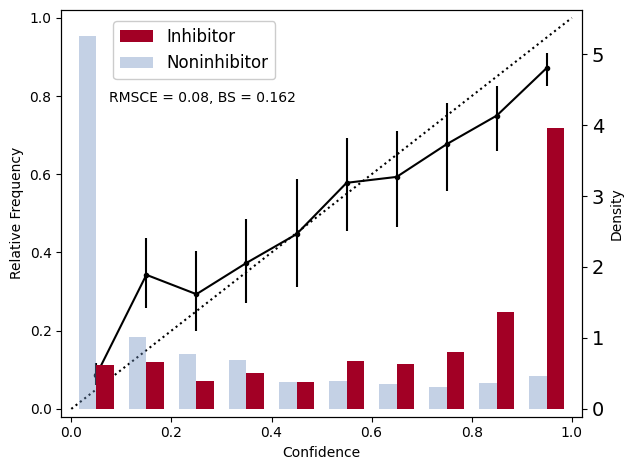

In [ ]:
ax, ax1 = reliability_diagram(val_proba_inhibitor, val_df.Inhibitor, nbins=10)
plt.tight_layout()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax1.tick_params(labelsize=14)
plt.legend(loc=(0.1, 0.83), prop={'size': 12.00}, fancybox=True, framealpha=1.0)
plt.savefig("lr_model_reliability_diagram.pdf", bbox_inches='tight', dpi=600)
plt.savefig("lr_model_reliability_diagram.svg", bbox_inches='tight', dpi=600)
plt.savefig("lr_model_reliability_diagram.png", bbox_inches='tight', dpi=600);

In [ ]:
from sklearn.calibration import CalibratedClassifierCV

lr_ps_cal = CalibratedClassifierCV(estimator=lr_model, method='sigmoid', cv='prefit')
lr_ps_cal.fit(val_fingerprints, val_df.Inhibitor)
val_proba_inhibitor_ps_cal = lr_ps_cal.predict_proba(val_fingerprints)[:, 1]

In [ ]:
lr_ir_cal = CalibratedClassifierCV(estimator=lr_model, method='isotonic', cv='prefit')
lr_ir_cal.fit(val_fingerprints, val_df.Inhibitor)
val_proba_inhibitor_ir_cal = lr_ir_cal.predict_proba(val_fingerprints)[:, 1]

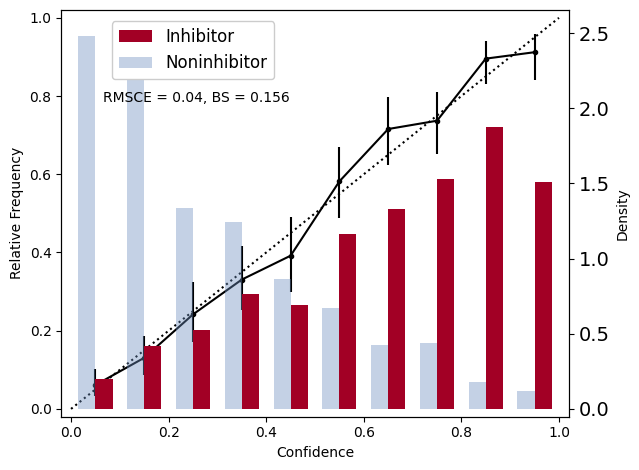

In [ ]:
ax, ax1 = reliability_diagram(val_proba_inhibitor_ps_cal, val_df.Inhibitor, nbins=10)
plt.tight_layout()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax1.tick_params(labelsize=14)
plt.legend(loc=(0.1, 0.83), prop={'size': 12.00},fancybox=True, framealpha=1.0)
plt.savefig("lr_model_platt_reliability_diagram.pdf", bbox_inches='tight', dpi=600)
plt.savefig("lr_model_platt_reliability_diagram.svg", bbox_inches='tight', dpi=600)
plt.savefig("lr_model_platt_reliability_diagram.png", bbox_inches='tight', dpi=600);

Unable to plot error bars


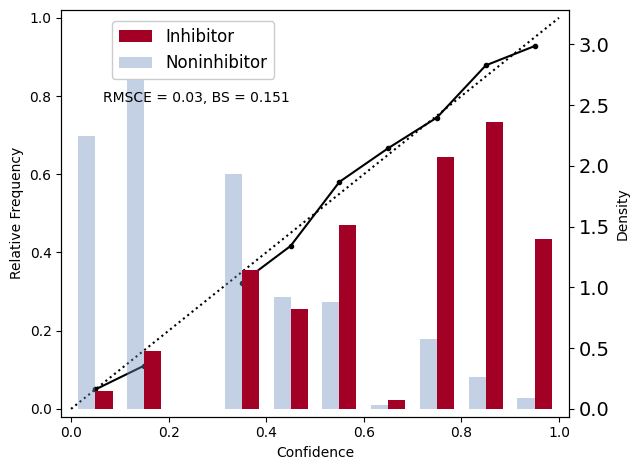

In [ ]:
ax, ax1 = reliability_diagram(val_proba_inhibitor_ir_cal, val_df.Inhibitor, nbins=10)
plt.tight_layout()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax1.tick_params(labelsize=14)
plt.legend(loc=(0.1, 0.83), prop={'size': 12.00},fancybox=True, framealpha=1.0)
plt.savefig("lr_model_isotonic_reliability_diagram.pdf", bbox_inches='tight', dpi=600)
plt.savefig("lr_model_isotonic_reliability_diagram.svg", bbox_inches='tight', dpi=600)
plt.savefig("lr_model_isotonic_reliability_diagram.png", bbox_inches='tight', dpi=600);

**Code for Figure 5.5. PR and ROC curves for the logistic regressor**

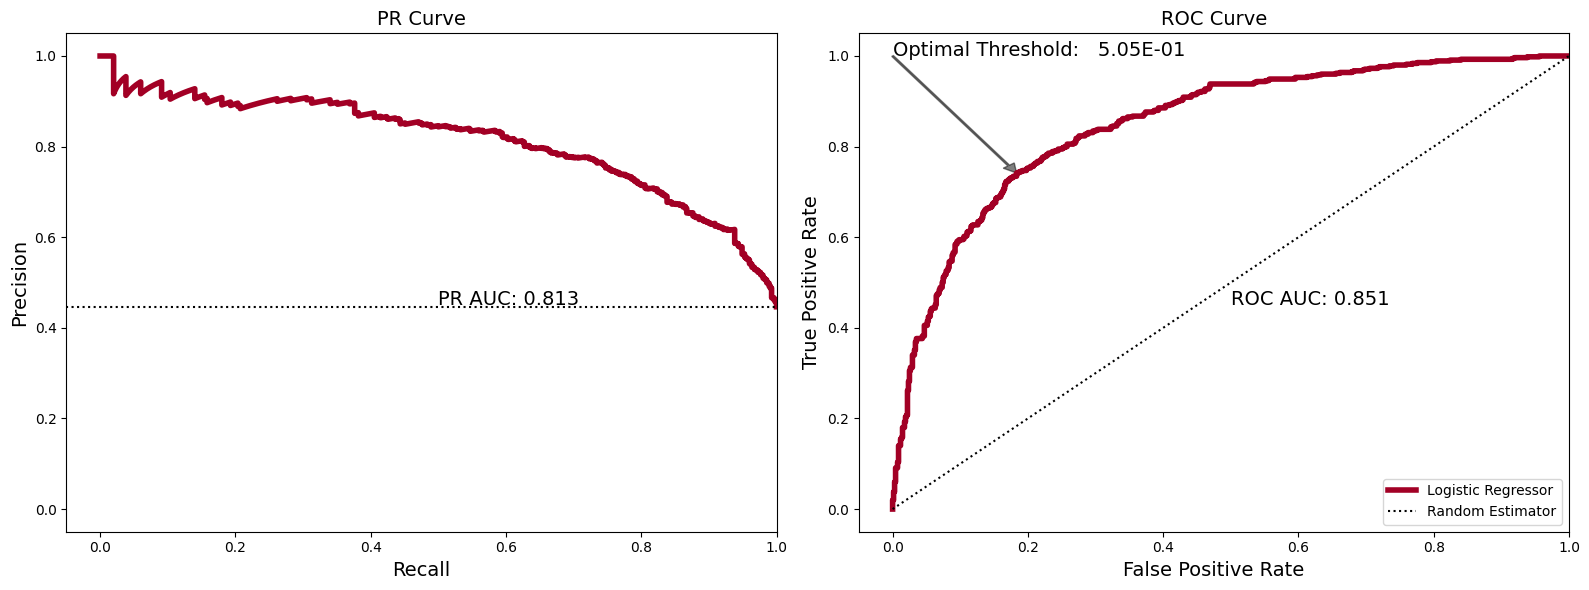

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

fpr, tpr, thresholds = metrics.roc_curve(val_df.Inhibitor, val_proba_inhibitor)
roc_curve_auc = metrics.auc(fpr, tpr)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

precision, recall, _ = metrics.precision_recall_curve(val_df.Inhibitor, val_proba_inhibitor)
pr_curve_auc = metrics.auc(recall, precision)
ax[0].plot(recall, precision, lw=4)

ax[0].axis([-0.05, 1.0, -0.05, 1.05])
skew = sum(val_df.Inhibitor) / len(val_df.Inhibitor)
ax[0].axhline(y=skew, color='black', linestyle='dotted')
ax[0].annotate("PR AUC: {:.3f}".format(pr_curve_auc), (0.5, 0.45), size=14)

ax[0].set_ylabel('Precision', fontsize=14)
ax[0].set_xlabel('Recall', fontsize=14)
ax[0].set_title("PR Curve", size=14)

ax[1].plot(fpr, tpr, label="Logistic Regressor", linewidth=4)
ax[1].plot(np.linspace(0.0, 1.0, 100), np.linspace(0.0, 1.0, 100), label='Random Estimator', color='black', linestyle='dotted')

ax[1].arrow(0, 1, fpr[optimal_idx], -1*(1-tpr[optimal_idx]), color="black", alpha=0.5, length_includes_head=True, head_width=0.02, head_length=0.02, shape='full', width=0.003)
ax[1].annotate("Optimal Threshold: {:10.2E}".format(optimal_threshold), (0., 1.), size=14)
ax[1].annotate("ROC AUC: {:.3f}".format(roc_curve_auc), (0.5, 0.45), size=14)

ax[1].axis([-0.05, 1.0, -0.05, 1.05])
ax[1].legend()

ax[1].set_ylabel('True Positive Rate', fontsize=14)
ax[1].set_xlabel('False Positive Rate', fontsize=14)
ax[1].set_title("ROC Curve", size=14)

fig.tight_layout()
fig.savefig('roc_and_pr_curves.png', bbox_inches='tight', dpi=600)
fig.savefig('roc_and_pr_curves.pdf', bbox_inches='tight', dpi=600);

## Tree-based Models

### Decision Trees

In [ ]:
from rdkit.Chem import Descriptors

RDKIT_DESCRIPTORS = {
  'MolWt' : Descriptors.MolWt,
  'logP' : Descriptors.MolLogP,
}

for desc, func in RDKIT_DESCRIPTORS.items():
  train_df[desc] = train_df["Molecule"].apply(func)
  val_df[desc] = val_df["Molecule"].apply(func)

In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree

tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(train_df[['MolWt', 'logP']], train_df.Inhibitor)

DecisionTreeClassifier(max_depth=2)

**Code for Figure 5.6. Visualization of basic two-descriptor decision tree**

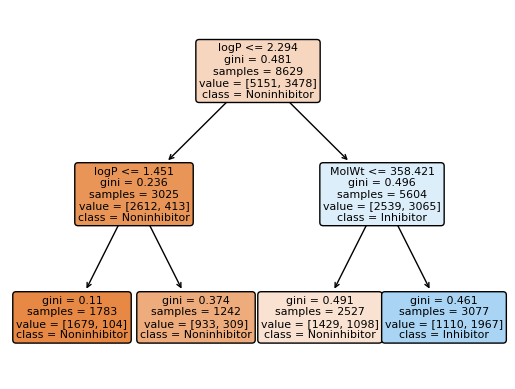

In [ ]:
plot_tree(tree_clf, feature_names=['MolWt', 'logP'], class_names=['Noninhibitor', 'Inhibitor'], rounded=True, filled=True);

In [ ]:
export_graphviz(
  tree_clf,
  out_file='tree.dot',
  feature_names=['MolWt', 'logP'],
  class_names=['Noninhibitor', 'Inhibitor'],
  rounded=True,
  filled=True
);

In [ ]:
!dot -Tpng tree.dot -o toy_DT.png

In [ ]:
!dot -Tpdf tree.dot -o toy_DT.pdf

In [ ]:
val_df['Predicted Class'] = tree_clf.predict(val_df[['MolWt', 'logP']])
val_df['Probability Estimate'] = tree_clf.predict_proba(val_df[['MolWt', 'logP']])[:,1]

In [ ]:
val_sample = pd.concat([
  val_df[(val_df['Predicted Class'] == 1)][:10],
  val_df[(val_df['Predicted Class'] == 1)][11:16],
])

In [ ]:
val_sample[['Drug', 'MolWt', 'logP', 'Predicted Class', 'Probability Estimate']]

,Drug,MolWt,logP,Predicted Class,Probability Estimate
0,COc1ccc(C(=O)N2CCC[C@@]3(CCN(Cc4ccccc4)C3)C2)cc1,364.489,3.82350,1,0.639259
1,COc1ccccc1CN1CC[C@@]2(CCCN(C(=O)c3cccc(F)c3)C2)C1,382.479,3.96260,1,0.639259
3,N#Cc1ccc(CN2CC[C@@]3(CCCN(C(=O)c4cc(C(F)(F)F)c...,495.467,5.72418,1,0.639259
4,O=C(c1cc(C(F)(F)F)cc(C(F)(F)F)c1)N1CCC[C@@]2(C...,470.457,5.85250,1,0.639259
5,COc1ccc(C(=O)N2CCC[C@@]3(CCN(Cc4ccccc4OC)C3)C2...,394.515,3.83210,1,0.639259
6,N#Cc1ccc(CN2CC[C@@]3(CCCN(C(=O)c4cccc(F)c4)C3)...,377.463,3.82568,1,0.639259
7,COc1ccc(C(=O)N2CCC[C@@]3(CCN(Cc4cc(C(F)(F)F)cc...,500.483,5.86110,1,0.639259
8,COc1ccc(C(=O)N2CCC[C@@]3(CCN(Cc4ccc(C#N)cc4)C3...,389.499,3.69518,1,0.639259
9,COc1ccccc1CN1CC[C@@]2(CCCN(C(=O)c3cc(C(F)(F)F)...,500.483,5.86110,1,0.639259
12,COc1cccc(CN2C(=O)N(C(C)C)C(N(O)C(=O)NC(C)C)C2(...,422.526,3.26370,1,0.639259


### Dealing with Data Set Imbalance

In [ ]:
def pr_auc_score(clf_, X, y):
  clf_proba = clf_.predict_proba(X)[:,1]
  clf_precision, clf_recall, _ = metrics.precision_recall_curve(y, clf_proba)
  return metrics.auc(clf_recall, clf_precision)

In [ ]:
inhibitors = train_df[train_df.Inhibitor == 1]
noninhibitors = train_df[train_df.Inhibitor == 0]
# Downsample noninhibitor class subset to same size as inhibitor class subset
train_df_downsampled = pd.concat([inhibitors, noninhibitors.sample(len(inhibitors))])
# Upsample inhibitor class subset to same size as noninhibitor class subset
train_df_upsampled = pd.concat([inhibitors.sample(len(noninhibitors), replace=True), noninhibitors])

In [ ]:
len(train_df_downsampled)

6956

In [ ]:
len(train_df_upsampled)

10302

In [ ]:
tree_clf = DecisionTreeClassifier().fit(train_fingerprints, train_df.Inhibitor)
down_sampled_tree_clf = DecisionTreeClassifier().fit(np.array(train_df_downsampled["fingerprints"].values.tolist()), train_df_downsampled.Inhibitor)
up_sampled_tree_clf = DecisionTreeClassifier().fit(np.array(train_df_upsampled["fingerprints"].values.tolist()), train_df_upsampled.Inhibitor)
wt_tree_clf = DecisionTreeClassifier(class_weight='balanced').fit(train_fingerprints, train_df.Inhibitor)

In [ ]:
print(f"LR Validation PR AUC: {pr_auc_score(lr_model, val_fingerprints, val_df.Inhibitor):.3f}")
print(f"DT Validation PR AUC: {pr_auc_score(tree_clf, val_fingerprints, val_df.Inhibitor):.3f}")
print(f"US DT Validation PR AUC: {pr_auc_score(down_sampled_tree_clf, val_fingerprints, val_df.Inhibitor):.3f}")
print(f"OS DT Validation PR AUC: {pr_auc_score(up_sampled_tree_clf, val_fingerprints, val_df.Inhibitor):.3f}")
print(f"Weighted DT Validation PR AUC: {pr_auc_score(wt_tree_clf, val_fingerprints, val_df.Inhibitor):.3f}")

LR Validation PR AUC: 0.813
DT Validation PR AUC: 0.724
US DT Validation PR AUC: 0.721
OS DT Validation PR AUC: 0.719
Weighted DT Validation PR AUC: 0.736


In [ ]:
print(f"LR Train PR AUC: {pr_auc_score(lr_model, train_fingerprints, train_df.Inhibitor)}")
print(f"DT Train PR AUC: {pr_auc_score(tree_clf, train_fingerprints, train_df.Inhibitor)}")
print(f"Weighted DT Train PR AUC: {pr_auc_score(wt_tree_clf, train_fingerprints, train_df.Inhibitor)}")

LR Train PR AUC: 0.9516638242935856
DT Train PR AUC: 0.9999989681253082
Weighted DT Train PR AUC: 0.9999989681253082


## Ensemble Learning: A Preview

### Random Forests: A Strong Collective of Weak Decision Trees

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=500, oob_score=True, n_jobs=-1, random_state=RANDOM_SEED)
rf_clf.fit(train_fingerprints, train_df.Inhibitor)
print(f"RF Validation PR AUC: {pr_auc_score(rf_clf, val_fingerprints, val_df.Inhibitor):.3f}")

RF Validation PR AUC: 0.837


In [ ]:
print(f"RF OOB Accuracy: {rf_clf.oob_score_:.3f}")

RF OOB Accuracy: 0.802


In [ ]:
pred_train = np.argmax(rf_clf.oob_decision_function_, axis=1)
clf_precision, clf_recall, _ = metrics.precision_recall_curve(train_df.Inhibitor, pred_train)
print(f"RF OOB PR AUC: {metrics.auc(clf_recall, clf_precision):.3f}")

RF OOB PR AUC: 0.806


In [ ]:
train_val_df = pd.concat([train_df, val_df])
rf_clf.fit(np.array(train_val_df["fingerprints"].values.tolist()), train_val_df.Inhibitor)

RandomForestClassifier(n_estimators=500, n_jobs=-1, oob_score=True,
                       random_state=42)

In [ ]:
print(f"Random Forest Test PR AUC: {pr_auc_score(rf_clf, test_fingerprints, test_df.Inhibitor):.3f}")

Random Forest Test PR AUC: 0.830


In [ ]:
bit_indices = np.argsort(rf_clf.feature_importances_)[::-1]
for i in range(10):
  print(f"{i + 1}. Fingerprint Bit {bit_indices[i]} : {rf_clf.feature_importances_[bit_indices[i]]:.5f}")

1. Fingerprint Bit 1750 : 0.01401
2. Fingerprint Bit 1088 : 0.00986
3. Fingerprint Bit 1603 : 0.00905
4. Fingerprint Bit 1536 : 0.00899
5. Fingerprint Bit 875 : 0.00876
6. Fingerprint Bit 841 : 0.00729
7. Fingerprint Bit 1152 : 0.00718
8. Fingerprint Bit 802 : 0.00667
9. Fingerprint Bit 781 : 0.00630
10. Fingerprint Bit 1873 : 0.00623


**Code for Figure 5.10. Similarity map for example validation set molecule**

In [ ]:
import io
from PIL import Image
from rdkit.Chem.Draw import SimilarityMaps as sm

def show_png(data):
  bio = io.BytesIO(data)
  img = Image.open(bio)
  return img

def sm_predict_proba(fp, pred_func):
  fp = np.array([list(fp)])
  return pred_func(fp)[0][1]

def sm_predict(fp, pred_func):
  fp = np.array([list(fp)])
  return pred_func(fp)[0]

def similarity_map(mol, model):
  d2d = Draw.MolDraw2DCairo(400, 400)
  dopts = d2d.drawOptions()
  dopts.useBWAtomPalette()

  _, maxweight = sm.GetSimilarityMapForModel(
    mol,
    sm.GetMorganFingerprint,
    lambda x: sm_predict_proba(x, model.predict_proba),
    draw2d=d2d,
  )

  d2d.FinishDrawing()
  return d2d, maxweight

In [ ]:
fig, maxweight = similarity_map(
  val_df.Molecule.values[6],
  rf_clf
)
print(f"Maximum Weight: {maxweight:.3f}")

Maximum Weight: 0.652


In [ ]:
png_image = show_png(fig.GetDrawingText())

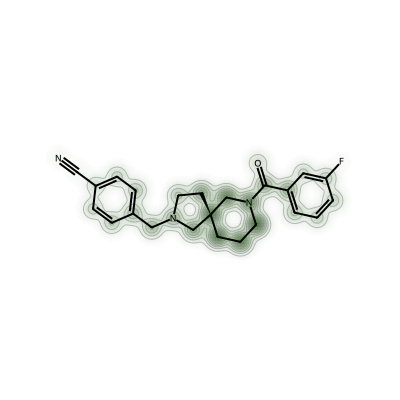

In [ ]:
png_image

In [ ]:
png_image.save("similarity_map_example.png")

In [ ]:
ad_threshold = 0.8
ad = np.amax(rf_clf.predict_proba(test_fingerprints), axis=1) > ad_threshold

In [ ]:
print(f"In Applicability Domain PR AUC: {pr_auc_score(rf_clf, test_fingerprints[ad], test_df.Inhibitor[ad]):.3f}")

In Applicability Domain PR AUC: 0.957


In [ ]:
print(f"Out of Applicability Domain PR AUC: {pr_auc_score(rf_clf, test_fingerprints[~ad], test_df.Inhibitor[~ad]):.3f}")

Out of Applicability Domain PR AUC: 0.713


In [ ]:
print(f"Coverage of Test Set by Model Applicability Domain: {sum(ad) / len(ad):.3%}")

Coverage of Test Set by Model Applicability Domain: 33.928%


In [ ]:
from sklearn.model_selection import train_test_split

def adversarial_validation(train, test):
    train['label'] = 0
    test['label'] = 1

    tmp_df = pd.concat([train, test])
    train, test = train_test_split(tmp_df)

    adv_rf_clf = RandomForestClassifier()
    adv_rf_clf.fit(np.array(train["fingerprints"].values.tolist()), train.label)

    pred = adv_rf_clf.predict(np.array(test["fingerprints"].values.tolist()))
    return pr_auc_score(adv_rf_clf, np.array(test["fingerprints"].values.tolist()), test.label)

In [ ]:
print(f"Adversarial Validation PR AUC: {adversarial_validation(train_val_df, test_df):.3f}")

Adversarial Validation PR AUC: 0.504


## Multiclass & Multilabel Classification

### Multilabel Classification

In [ ]:
from rdkit.Chem import MolToInchi, MolFromInchi
def process_cyp_data(cyp):
  df = ADME(name = f'{cyp}_Veith').get_data()
  df = df.rename(columns={'Y':f'{cyp}'})
  PandasTools.AddMoleculeColumnToFrame(df, "Drug", "Molecule")
  df['Inchi'] = df.Molecule.apply(MolToInchi)
  df = df.dropna()
  return df

cyps = ['CYP2C19', 'CYP2D6', 'CYP3A4', 'CYP1A2', 'CYP2C9']
cyp_inhibitor_dfs = [process_cyp_data(cyp) for cyp in cyps]

Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!


In [ ]:
cyp_inhibitor_df = cyp_inhibitor_dfs[0]
for df in cyp_inhibitor_dfs[1:]:
  cyp_inhibitor_df = cyp_inhibitor_df.merge(df, on='Inchi', how='inner')

In [ ]:
cyp_inhibitor_df = cyp_inhibitor_df[['Molecule', 'CYP2C19', 'CYP2D6', 'CYP3A4', 'CYP1A2', 'CYP2C9']]

In [ ]:
cyp_inhibitor_df['fingerprints'] = df['Molecule'].apply(compute_fingerprint, r=2, nBits=2048)

In [ ]:
from skmultilearn.model_selection import IterativeStratification
from sklearn.multioutput import MultiOutputClassifier
from skmultilearn.model_selection import iterative_train_test_split

X = cyp_inhibitor_df["fingerprints"]
y = cyp_inhibitor_df[cyps]

stratifier = IterativeStratification(n_splits=2, order=2, sample_distribution_per_fold=[0.2, 0.8])
train_indexes, test_indexes = next(stratifier.split(X, y))
X_train, y_train = X.loc[train_indexes], y.loc[train_indexes]
X_test, y_test = X.loc[test_indexes], y.loc[test_indexes]

In [ ]:
lr_clf = MultiOutputClassifier(LogisticRegression()).fit(np.array(X_train.values.tolist()), y_train)
lr_y_pred = lr_clf.predict(np.array(X_test.values.tolist()))
lr_y_pred_proba = lr_clf.predict_proba(np.array(X_test.values.tolist()))

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1).fit(np.array(X_train.values.tolist()), y_train)
rf_y_pred = rf_clf.predict(np.array(X_test.values.tolist()))
rf_y_pred_proba = rf_clf.predict_proba(np.array(X_test.values.tolist()))

**Code for Figure 5.12. PR curves and AUC performance on our custom multilabel classification task**

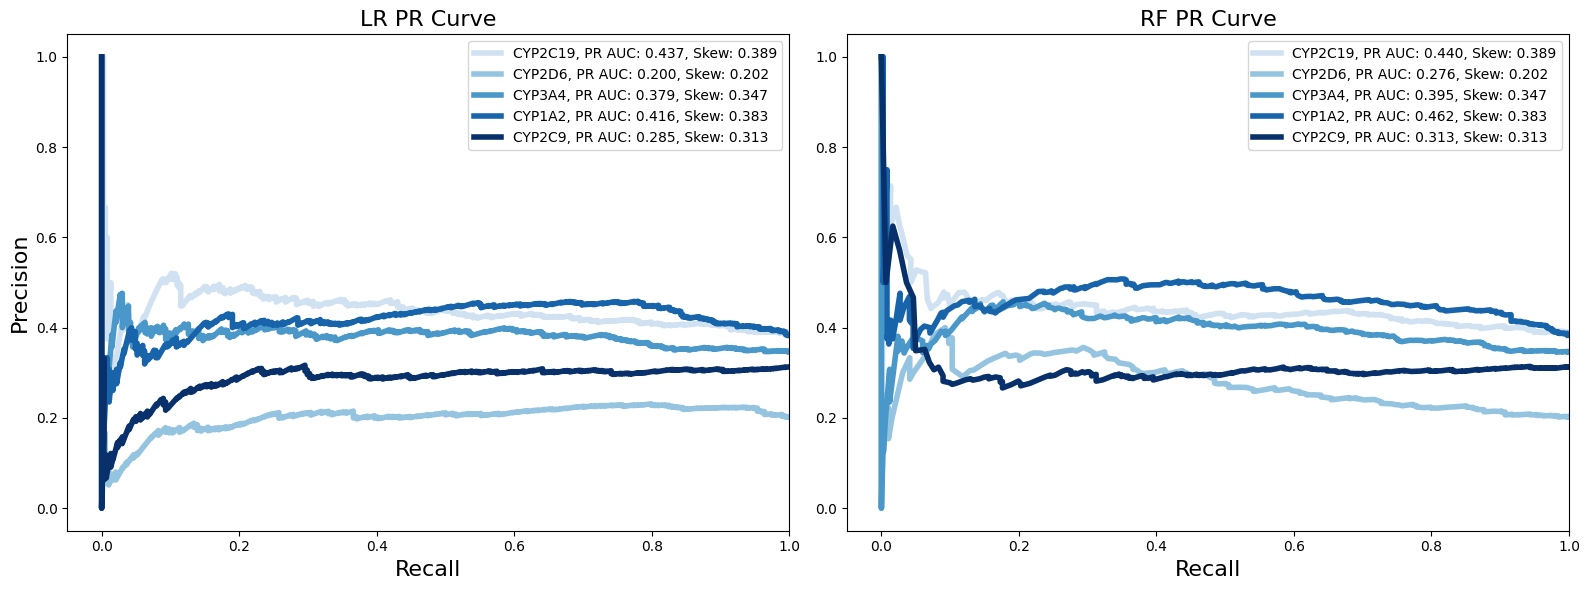

In [ ]:
from matplotlib import cm

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
cmap = cm.Blues(np.linspace(0.2,1,5))

for idx, cyp_label in enumerate(cyps):
  precision, recall, _ = metrics.precision_recall_curve(y_test[cyp_label], lr_y_pred_proba[idx][:,0])
  pr_curve_auc = metrics.auc(recall, precision)
  ax[0].plot(recall, precision, lw=4, label=f'{cyp_label}, PR AUC: {pr_curve_auc:.3f}, Skew: {sum(y_test[cyp_label])/len(y_test[cyp_label]):.3f}', color=cmap[idx])

ax[0].axis([-0.05, 1.0, -0.05, 1.05])
ax[0].set_ylabel('Precision', fontsize=16)
ax[0].set_xlabel('Recall', fontsize=16)
ax[0].set_title("LR PR Curve", size=16)
ax[0].legend()

for idx, cyp_label in enumerate(cyps):
  precision, recall, _ = metrics.precision_recall_curve(y_test[cyp_label], rf_y_pred_proba[idx][:,0])
  pr_curve_auc = metrics.auc(recall, precision)
  ax[1].plot(recall, precision, lw=4, label=f'{cyp_label}, PR AUC: {pr_curve_auc:.3f}, Skew: {sum(y_test[cyp_label])/len(y_test[cyp_label]):.3f}', color=cmap[idx])

ax[1].axis([-0.05, 1.0, -0.05, 1.05])
ax[1].set_xlabel('Recall', fontsize=16)
ax[1].set_title("RF PR Curve", size=16)
ax[1].legend()

fig.tight_layout()
fig.savefig('multilabel_pr_curves.png', bbox_inches='tight', dpi=600)
fig.savefig('multilabel_pr_curves.pdf', bbox_inches='tight', dpi=600);

In [ ]:
from sklearn.metrics import (
    classification_report,
    coverage_error,
    multilabel_confusion_matrix,
    label_ranking_loss,
)

In [ ]:
print(classification_report(y_test, rf_y_pred, target_names=cyps))

              precision    recall  f1-score   support

     CYP2C19       0.31      0.27      0.29       374
      CYP2D6       0.00      0.00      0.00       194
      CYP3A4       0.25      0.13      0.17       333
      CYP1A2       0.24      0.18      0.21       368
      CYP2C9       0.36      0.19      0.25       301

   micro avg       0.29      0.17      0.21      1570
   macro avg       0.23      0.15      0.18      1570
weighted avg       0.25      0.17      0.20      1570
 samples avg       0.13      0.10      0.10      1570



In [ ]:
print(f"LR Coverage Error: {coverage_error(y_test, lr_y_pred):.3f}")
print(f"RF Coverage Error: {coverage_error(y_test, rf_y_pred):.3f}")

LR Coverage Error: 2.863
RF Coverage Error: 2.862


In [ ]:
print(f"LR Ranking Loss: {label_ranking_loss(y_test, lr_y_pred):.3f}")
print(f"RF Ranking Loss: {label_ranking_loss(y_test, rf_y_pred):.3f}")

LR Ranking Loss: 0.481
RF Ranking Loss: 0.476


In [ ]:
lr_ml_conf_mx = multilabel_confusion_matrix(y_test, lr_y_pred)

Text(0.5, 0.93, 'CYP Inhibitor Confusion Matrices')

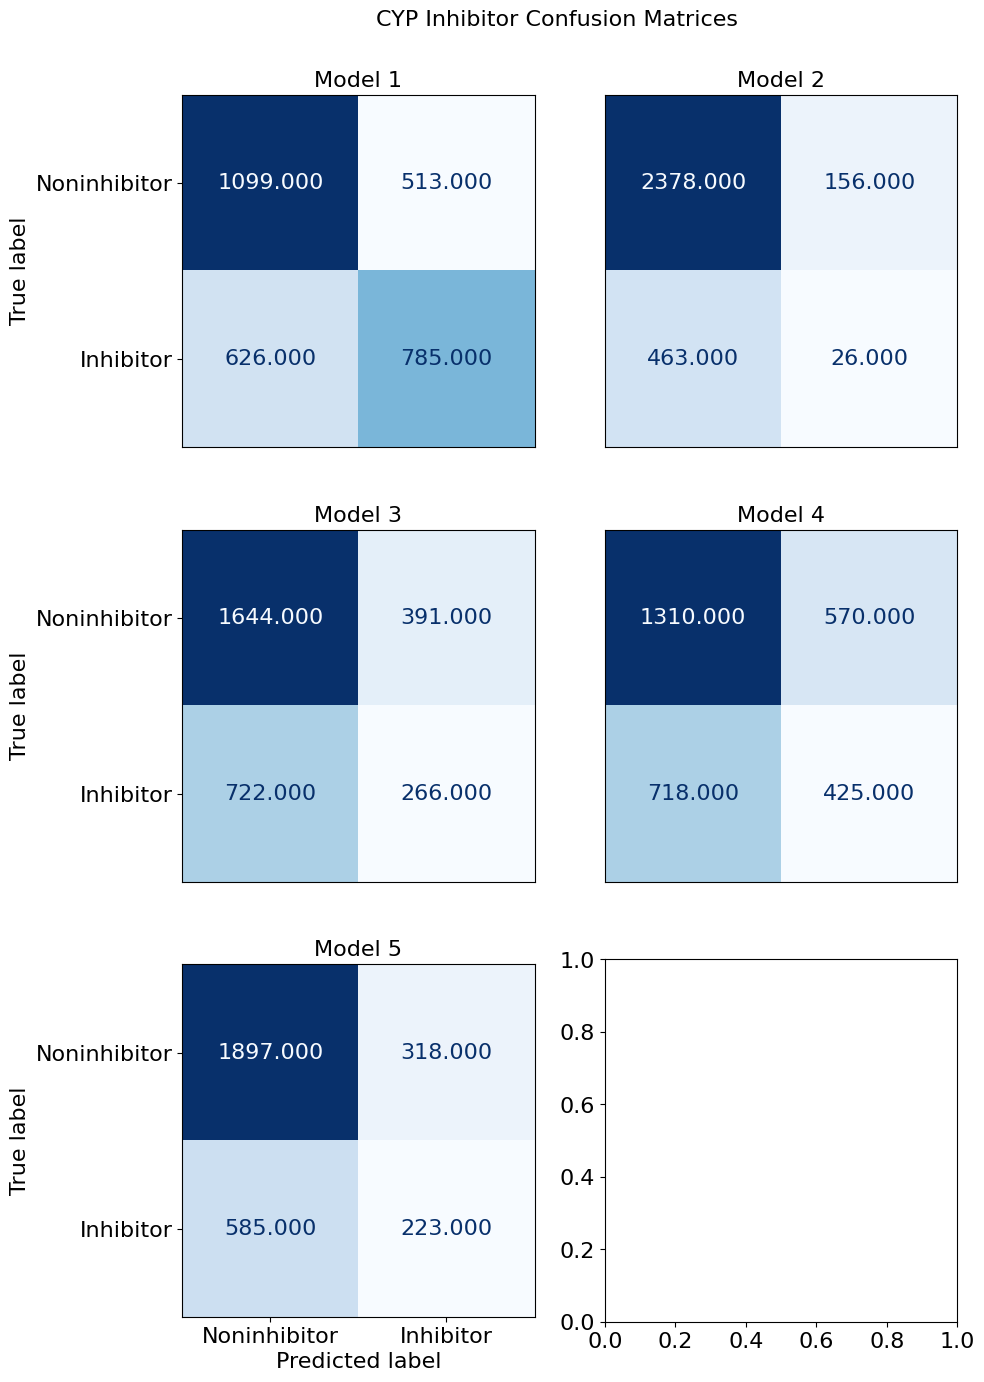

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

title_size = 16
plt.rcParams.update({'font.size':16})
display_labels = ['Noninhibitor', 'Inhibitor']
colorbar = False
cmap = "Blues"
values_format = ".3f"

f, axes = plt.subplots(3, 2, figsize=(10, 16))

axes[0, 0].set_title("Model 1", size=title_size)
ConfusionMatrixDisplay(confusion_matrix=lr_ml_conf_mx[0], display_labels=display_labels).plot(
    include_values=True, cmap=cmap, ax=axes[0, 0], colorbar=colorbar, values_format=values_format)

axes[0, 0].xaxis.set_ticklabels(['', ''])
axes[0, 0].set_xlabel('')
axes[0, 0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)


axes[0, 1].set_title("Model 2", size=title_size)
ConfusionMatrixDisplay(confusion_matrix=lr_ml_conf_mx[1], display_labels=display_labels).plot(
    include_values=True, cmap=cmap, ax=axes[0, 1], colorbar=colorbar, values_format=values_format)

axes[0, 1].xaxis.set_ticklabels(['', ''])
axes[0, 1].yaxis.set_ticklabels(['', ''])
axes[0, 1].set_xlabel('')
axes[0, 1].set_ylabel('')
axes[0, 1].tick_params(axis='both', which='both', bottom=False, left=False)

axes[1, 0].set_title("Model 3", size=title_size)
ConfusionMatrixDisplay(confusion_matrix=lr_ml_conf_mx[2], display_labels=display_labels).plot(
    include_values=True, cmap=cmap, ax=axes[1, 0], colorbar=colorbar, values_format=values_format)

# Remove x-axis labels and ticks
axes[1, 0].xaxis.set_ticklabels(['', ''])
axes[1, 0].set_xlabel('')
axes[1, 0].tick_params(axis='x', which='both', bottom=False)

axes[1, 1].set_title("Model 4", size=title_size)
ConfusionMatrixDisplay(confusion_matrix=lr_ml_conf_mx[3], display_labels=display_labels).plot(
    include_values=True, cmap=cmap, ax=axes[1, 1], colorbar=colorbar, values_format=values_format)

axes[1, 1].xaxis.set_ticklabels(['', ''])
axes[1, 1].yaxis.set_ticklabels(['', ''])
axes[1, 1].set_xlabel('')
axes[1, 1].set_ylabel('')
axes[1, 1].tick_params(axis='both', which='both',bottom=False, left=False)

axes[2, 0].set_title("Model 5", size=title_size)
ConfusionMatrixDisplay(confusion_matrix=lr_ml_conf_mx[4], display_labels=display_labels).plot(
    include_values=True, cmap=cmap, ax=axes[2, 0], colorbar=colorbar, values_format=values_format)

f.suptitle("CYP Inhibitor Confusion Matrices", size=title_size, y=0.93)